# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/monet-generative-adversarial-network
- Data Source: https://www.kaggle.com/competitions/gan-getting-started/data (Jang et al., 2020)
- Python version: 3.13

## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **Generative Adversarial Network (GAN)** deep learning problem. The task is to build a GAN which can convert photos to look like paintings by Claude Monet.

**Project Goal:** Build a GAN which can convert photos to look like paintings by Claude Monet.

## Data Description ##

The dataset contains 300 Monet paintings sized 256x256 in JPEG format and 7028 photos sized 256x256 in JPEG format. (Jang et al., 2020)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from tensorflow.keras.utils import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Exploratory Data Analysis #

## Data Loading ##

Because the total data size is quite large (almost 2 GB), I will load only 100 Monet paintings and photos into RAM and do EDA on a subset. This will still give a reasonable approximation of the differences between the data sets.


In [2]:
def load_images(image_files, parent_path):
    r_pixels = []
    g_pixels = []
    b_pixels = []
    image_arrays = []
    for filename in image_files:
        img_path = os.path.join(parent_path, filename)
        img = load_img(img_path)  # Load at original size
        img_array = img_to_array(img).astype(np.uint8)  # Shape: (height, width, 3)
        image_arrays.append(img_array)

        # Flatten and append to respective channels
        r_pixels.extend(img_array[:, :, 0].flatten())
        g_pixels.extend(img_array[:, :, 1].flatten())
        b_pixels.extend(img_array[:, :, 2].flatten())

    return image_arrays, r_pixels, g_pixels, b_pixels


monet_path = 'data/monet_jpg'
photos_path = 'data/photo_jpg'
monet_image_files = [f for f in os.listdir(monet_path) if f.endswith('.jpg')]
photo_image_files = [f for f in os.listdir(photos_path) if f.endswith('.jpg')]

print(f"Loading {len(monet_image_files)} monet images...")
monet_image_arrays, monet_r_pixels, monet_g_pixels, monet_b_pixels = load_images(monet_image_files[:100], monet_path)

print(f"Loading {len(photo_image_files)} photo images...")
photo_image_arrays, photo_r_pixels, photo_g_pixels, photo_b_pixels = load_images(photo_image_files[:100], photos_path)


Loading 300 monet images...
Loading 7038 photo images...


In [3]:
print(f"First image shape: {monet_image_arrays[0].shape}")
print(f"Memory usage estimate: {len(monet_image_arrays) * monet_image_arrays[0].size * monet_image_arrays[0].itemsize / 1024 / 1024:.1f} MB")

print(f"First image shape: {photo_image_arrays[0].shape}")
print(f"Memory usage estimate: {len(photo_image_arrays) * photo_image_arrays[0].size * photo_image_arrays[0].itemsize / 1024 / 1024:.1f} MB")


First image shape: (256, 256, 3)
Memory usage estimate: 18.8 MB
First image shape: (256, 256, 3)
Memory usage estimate: 18.8 MB


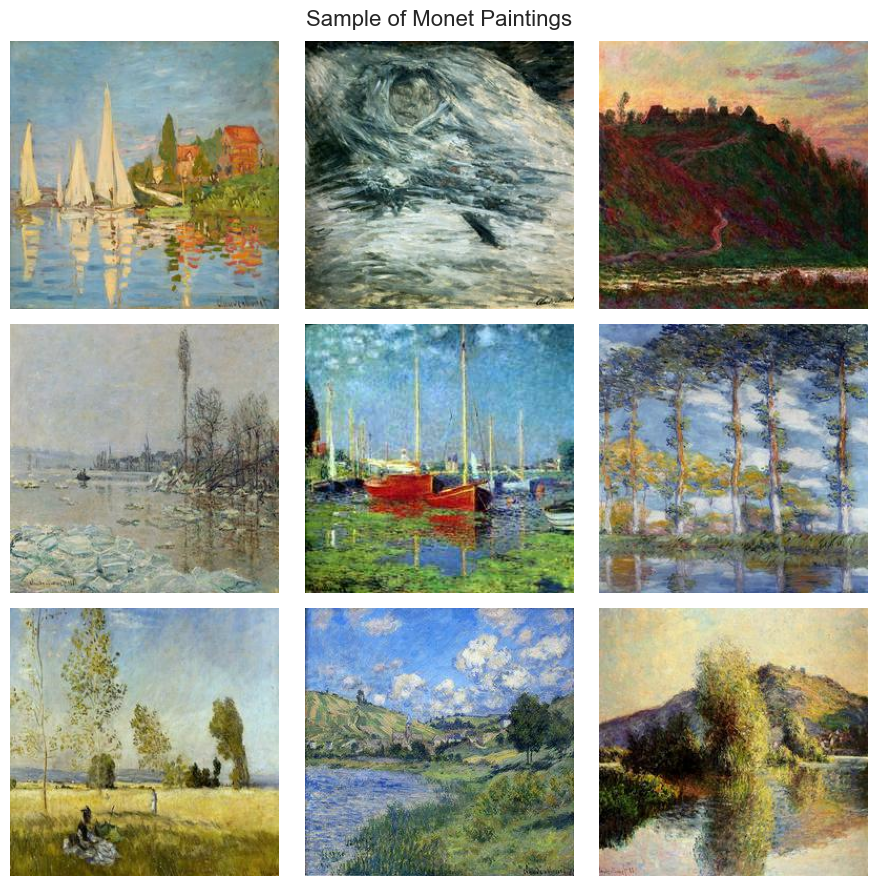

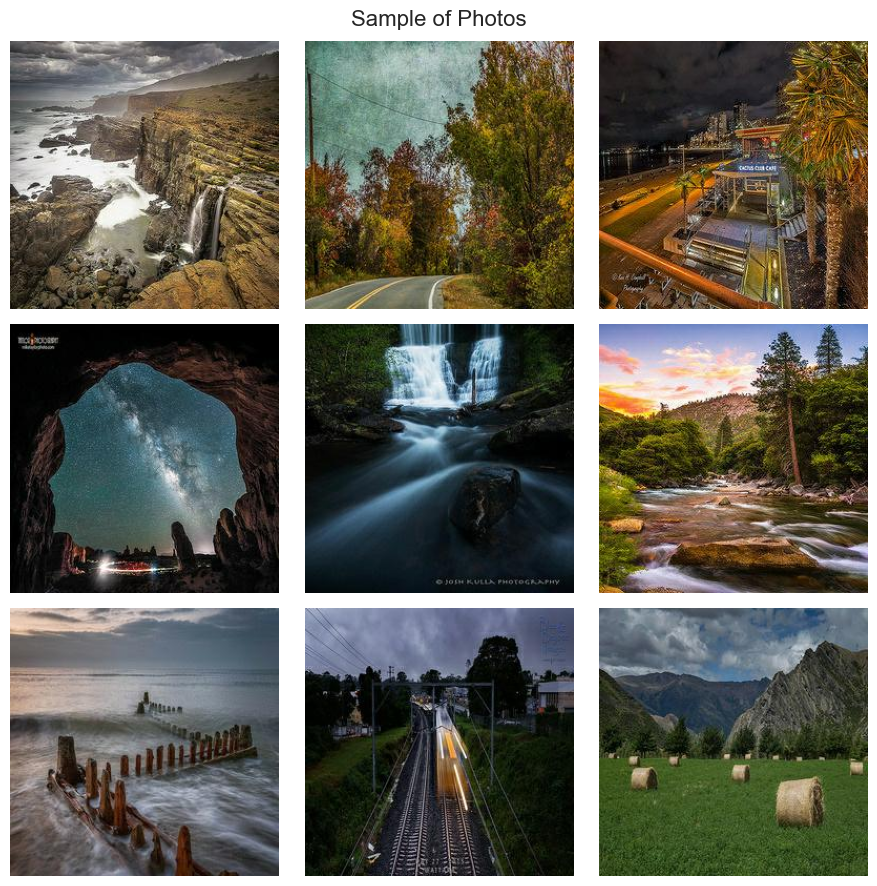

In [6]:
def display_image_grid(image_arrays, title):
    num_images = 9
    rows = 3
    cols = 3

    # Create subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    axes = axes.ravel()

    for i in range(num_images):
        img = image_arrays[i]
        # Display on subplot
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(f'Sample of {title}', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

display_image_grid(monet_image_arrays, 'Monet Paintings')
display_image_grid(photo_image_arrays, 'Photos')

## Data Exploration and Visualization ##

We will start by exploring the distribution of pixel intensity in each channel (RGB) in the monet images vs the photos.




Computing Monet RGB Histogram ...


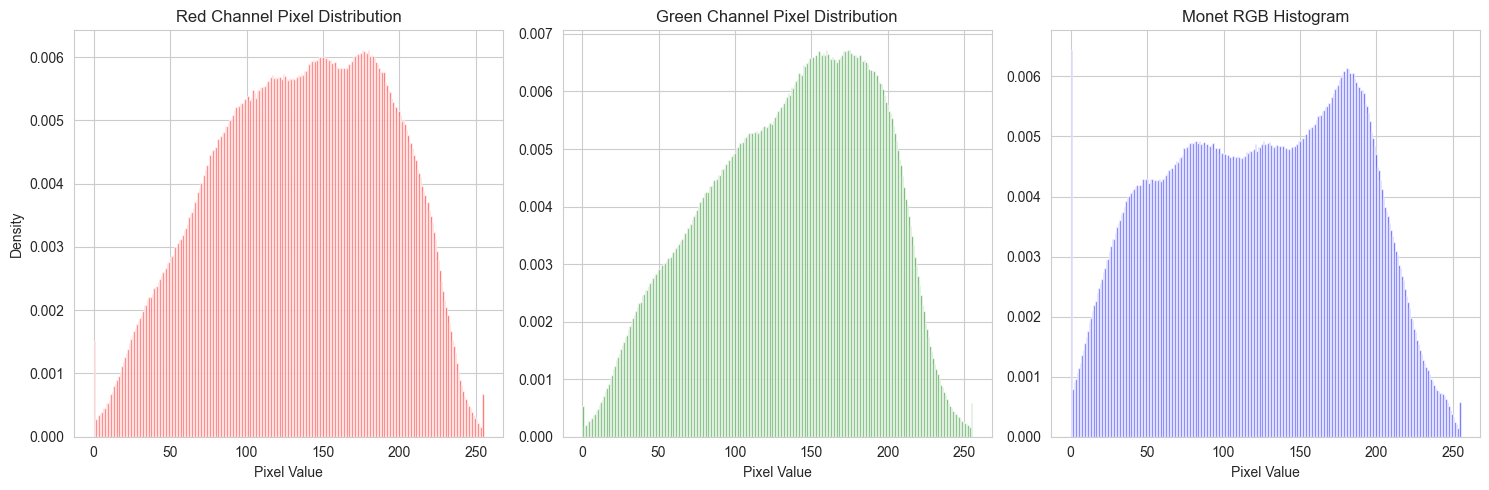

Computing Photo RGB Histogram ...


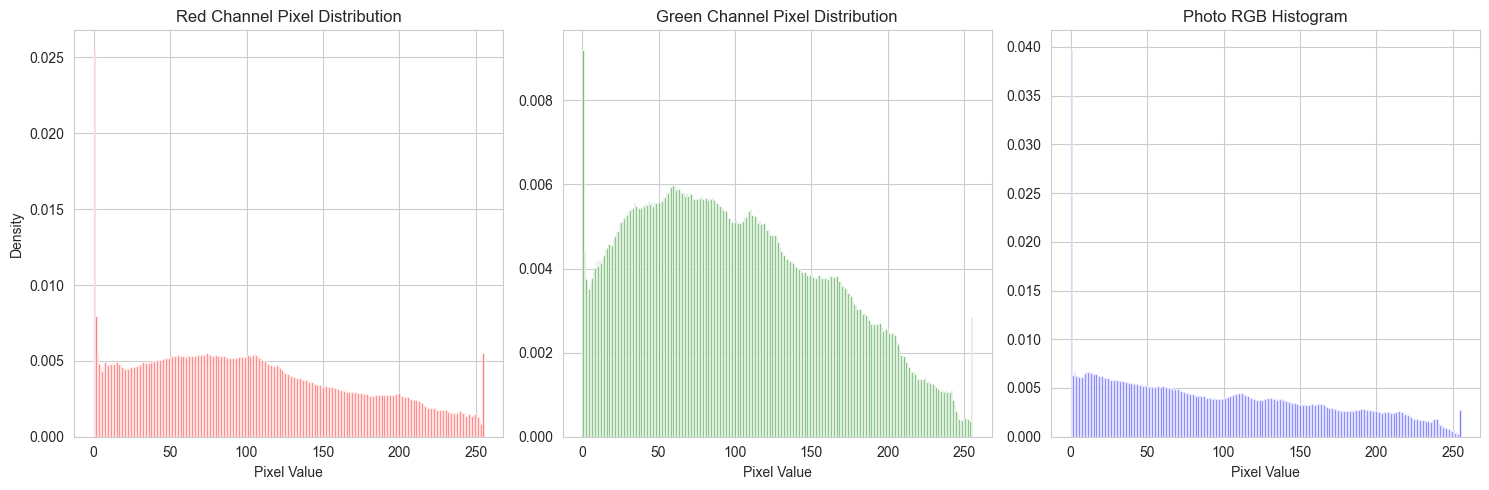


******Monet RGB Statistics******

Total pixels analyzed: 6,553,600
Red channel - Mean: 135.27, Std: 55.91
Green channel - Mean: 136.36, Std: 54.22
Blue channel - Mean: 122.91, Std: 61.01

******Photo RGB Statistics******

Total pixels analyzed: 6,553,600
Red channel - Mean: 101.89, Std: 67.60
Green channel - Mean: 100.95, Std: 62.15
Blue channel - Mean: 95.76, Std: 69.43


In [9]:
def display_rgb_histograms(r_pixels, g_pixels, b_pixels, title):
    print(f"Computing {title} ...")

    r_pixels = np.array(r_pixels)
    g_pixels = np.array(g_pixels)
    b_pixels = np.array(b_pixels)

    # Create histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Red channel
    axes[0].hist(r_pixels, bins=256, range=(0, 255), color='red', alpha=0.7, density=True)
    axes[0].set_title('Red Channel Pixel Distribution')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Density')

    # Green channel
    axes[1].hist(g_pixels, bins=256, range=(0, 255), color='green', alpha=0.7, density=True)
    axes[1].set_title('Green Channel Pixel Distribution')
    axes[1].set_xlabel('Pixel Value')

    # Blue channel
    axes[2].hist(b_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7, density=True)
    axes[2].set_title('Blue Channel Pixel Distribution')
    axes[2].set_xlabel('Pixel Value')

    plt.title(title)
    plt.tight_layout()
    plt.show()


def print_pixel_stats(r_pixels, g_pixels, b_pixels, title):

    r_pixels = np.array(r_pixels)
    g_pixels = np.array(g_pixels)
    b_pixels = np.array(b_pixels)

    print("")
    print(f"******{title}******")
    print("")
    print(f"Total pixels analyzed: {len(r_pixels):,}")
    print(f"Red channel - Mean: {r_pixels.mean():.2f}, Std: {r_pixels.std():.2f}")
    print(f"Green channel - Mean: {g_pixels.mean():.2f}, Std: {g_pixels.std():.2f}")
    print(f"Blue channel - Mean: {b_pixels.mean():.2f}, Std: {b_pixels.std():.2f}")


display_rgb_histograms(monet_r_pixels, monet_g_pixels, monet_b_pixels, "Monet RGB Histogram")
display_rgb_histograms(photo_r_pixels, photo_g_pixels, photo_b_pixels, "Photo RGB Histogram")

print_pixel_stats(monet_r_pixels, monet_g_pixels, monet_b_pixels, "Monet RGB Statistics")
print_pixel_stats(photo_r_pixels, photo_g_pixels, photo_b_pixels, "Photo RGB Statistics")



**Results**
We can see significant differences in the average and standard deviation of pixel values when comparing money to photos. We can also see the photos are much darker (lower pixel intensity) that the Monet paintings. This darkeness strikes me as the most obvious difference when looking at the sample images displayed above.

**Further Analysis**
I hypothesize that the photos include far more "sharp lines" than the monet images. To analyze this, I will calculate the maximum pixel intensity difference for every 5x5 pixel block. Large differences indicate sharp lines. I will do this in gray scale to measure the difference across all three channels. (GeeksforGeeks, 2025)

Total blocks analyzed: 6,350,400


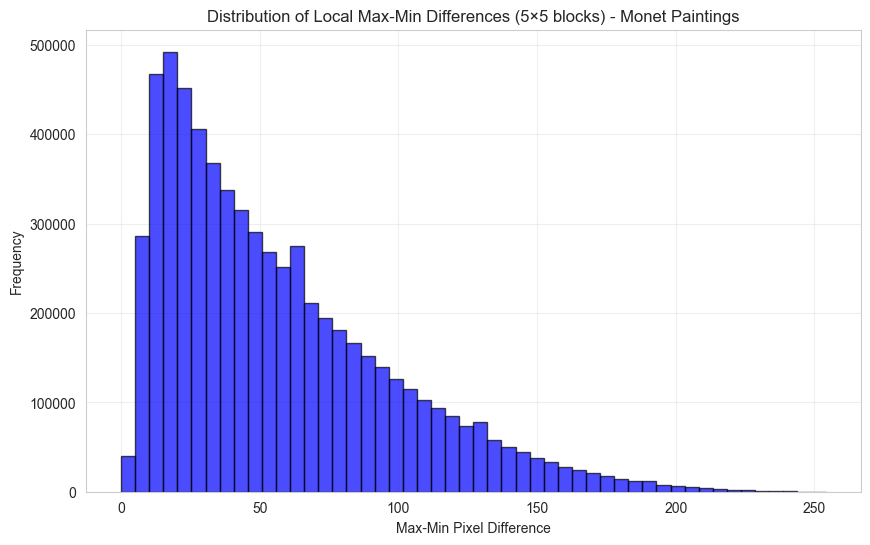


Sharpness statistics across all blocks:
Mean max-min difference: 56.37
Median: 46.00
Std: 40.89
Max difference: 254
Percentage of blocks with diff > 50: 45.6%
Percentage of blocks with diff > 100: 15.0%
Total blocks analyzed: 6,350,400


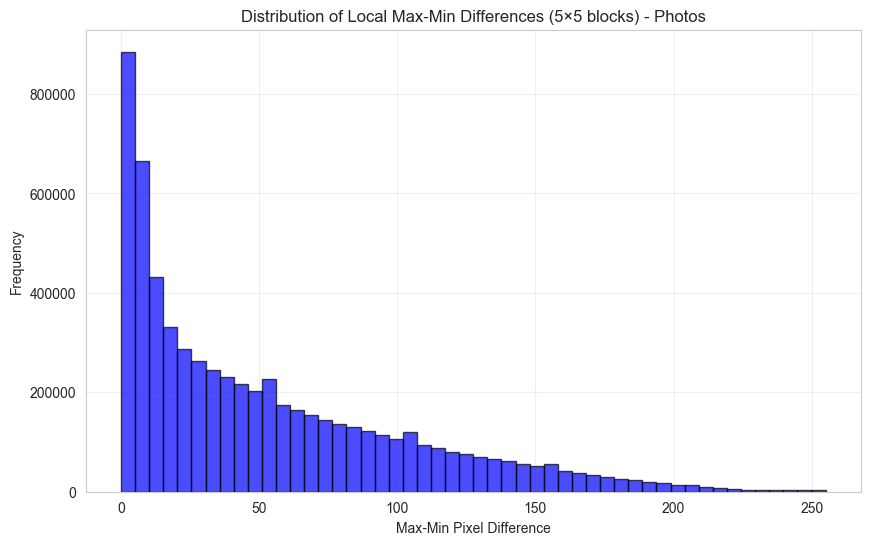


Sharpness statistics across all blocks:
Mean max-min difference: 52.96
Median: 37.00
Std: 50.55
Max difference: 255
Percentage of blocks with diff > 50: 40.8%
Percentage of blocks with diff > 100: 18.0%


In [10]:
def plot_max_intensity_distribution(img_arrays, title):
    # Collect all local max differences
    all_max_diffs = []

    for img_array in img_arrays:

        # Convert to grayscale (GeeksforGeeks, 2025)
        gray_img = np.dot(img_array.astype(np.float32), [0.299, 0.587, 0.114]).astype(np.uint8)

        # Apply 5x5 sliding window max-min difference
        # We'll use stride 1 for detailed analysis
        height, width = gray_img.shape
        block_size = 5

        for i in range(0, height - block_size + 1):
            for j in range(0, width - block_size + 1):
                block = gray_img[i:i+block_size, j:j+block_size]
                max_diff = block.max() - block.min()
                all_max_diffs.append(max_diff)

    print(f"Total blocks analyzed: {len(all_max_diffs):,}")

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_max_diffs, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of Local Max-Min Differences (5×5 blocks) - {title}')
    plt.xlabel('Max-Min Pixel Difference')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

    # Statistics
    all_max_diffs = np.array(all_max_diffs)
    print(f"\nSharpness statistics across all blocks:")
    print(f"Mean max-min difference: {all_max_diffs.mean():.2f}")
    print(f"Median: {np.median(all_max_diffs):.2f}")
    print(f"Std: {all_max_diffs.std():.2f}")
    print(f"Max difference: {all_max_diffs.max()}")
    print(f"Percentage of blocks with diff > 50: {(all_max_diffs > 50).mean()*100:.1f}%")
    print(f"Percentage of blocks with diff > 100: {(all_max_diffs > 100).mean()*100:.1f}%")


plot_max_intensity_distribution(monet_image_arrays, 'Monet Paintings')
plot_max_intensity_distribution(photo_image_arrays, 'Photos')


**Results:**
The hypothesis was incorrect. While there is a differnece between the paitings and photos, the monet paintings tend to have a higher difference between min and max pixel intensity compared to the photos. This is probably related to the subtle interleaving of colors in Monet's brushstrokes.



## Plan of Analysis ##

Because the data set is large, I will use a Tensorflow dataset to avoid loading all the data into memory at the same time. I will normalize the pixels moving them from 0 - 255 to -1 - +1. I will use a CycleGAN architecture which is the current state of the art for tasks such as this. The original CycleGAN paper used a ResNet style generator (Zhu et al., 2020). The TensorFlow CycleGAN tutorial uses a U-Net style generator. (Cyclegan:Tensorflow Core 2024). I will try both architectures with different learning rate and optimizer beta hyperparameters.

**Data Cleaning and Normalization** I will normalize the pixels moving them from 0 - 255 to -1 - +1 while loading the data in the generators. I will also oversample the Monet paintings because there are so many more photos that paintings.



In [ ]:
#Mount google drive and copy data for running on Colab TPUs
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#unzip the data
!cp '/content/drive/My Drive/data/GAN/gan-getting-started.zip' '/content/'


In [ ]:
!rm -rf '/content/data/'
!unzip -q '/content/gan-getting-started.zip' -d '/content/data/'

In [ ]:
print(tf.config.list_physical_devices('GPU'))

In [11]:

def load_image(file_path, target_size=(256, 256)):
    """Load and preprocess a single image"""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

def create_tf_dataset(file_paths, batch_size=1):
    """Create batched dataset from directory"""

    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = (dataset
               .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
               .shuffle(buffer_size=len(file_paths))
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))
    return dataset

def create_split_datasets(monet_path, photo_path):
    # Load all paths
    monet_files = [os.path.join(monet_path, f) for f in os.listdir(monet_path) if f.endswith('.jpg')]
    photo_files = [os.path.join(photo_path, f) for f in os.listdir(photo_path) if f.endswith('.jpg')]

    # Since unpaired, split each domain independently
    monet_train, monet_val = train_test_split(monet_files, test_size=0.2, random_state=42)

    photo_train, photo_val = train_test_split(photo_files, test_size=0.2, random_state=42)


    return {
        'monet_train': create_tf_dataset(monet_train, batch_size=1),
        'photo_train': create_tf_dataset(photo_train, batch_size=1),
        'monet_val': create_tf_dataset(monet_val, batch_size=1),
        'photo_val': create_tf_dataset(photo_val, batch_size=1),
    }

# Create datasets
#these paths assume Google Colab
dataset_dict = create_split_datasets('/content/data/monet_jpg', '/content/data/photo_jpg')

# Create paired dataset for CycleGAN training
train_dataset = tf.data.Dataset.zip((dataset_dict['photo_train'], dataset_dict['monet_train']))
train_dataset = train_dataset.shuffle(100).batch(1)  # Batch pairs for iteration



FileNotFoundError: [Errno 2] No such file or directory: '/content/data/monet_jpg'

# Model Architecture #

The ResNet Generator Architector attempts to implement the design described in the original CycleGAN paper. (Zhu et al., 2020) This has become a well known approach for solving problems such as this one. It includes:
- initial convolution
- two downsampling layers
- nine residual blocks
- and two upsampling layers
- tanh activation for output

The UNet Generator Archtecture attempts to implement an architecture as described in the TensorFlow CycleGAN tutorial. (Cyclegan:Tensorflow Core 2024) It includes:
- An Encoder with 2D convolution layers 64, 128, 256, 512
- A Bottleneck with normalization
- A Decoder that goes 512, 256, 128, 64
- A tanh output

These two approaches have become well-known industry standards and it will be interesting to see which performs better on this dataset.

The discriminator is a 70x70 PatchGAN as described in the Pix2Pix paper. (Isola et al., 2016) It is essentially a series of downsampling blocks (Conv2D with strides=2) that shrink the image until the final layer outputs them 70x70 grid of patch predictions

In [13]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, Input
from tensorflow_addons.layers import InstanceNormalization

# Define residual block
def residual_block(x, filters):
    # Two conv layers with residual connection
    res_x = Conv2D(filters, 3, padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = ReLU()(res_x)
    res_x = Conv2D(filters, 3, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    return x + res_x

def resnet_generator():
    inputs = Input((256, 256, 3))

    # Initial conv
    x = Conv2D(64, 7, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Downsampling
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Residual blocks (9 as in CycleGAN)
    for _ in range(9):
        x = residual_block(x, 256)

    # Upsampling
    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Output
    output = Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, output)

def unet_generator():
    inputs = Input((256, 256, 3))

    # Encoder
    enc1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    enc1 = LeakyReLU(0.2)(enc1)

    enc2 = Conv2D(128, 4, strides=2, padding='same')(enc1)
    enc2 = InstanceNormalization()(enc2)
    enc2 = LeakyReLU(0.2)(enc2)

    enc3 = Conv2D(256, 4, strides=2, padding='same')(enc2)
    enc3 = InstanceNormalization()(enc3)
    enc3 = LeakyReLU(0.2)(enc3)

    enc4 = Conv2D(512, 4, strides=2, padding='same')(enc3)
    enc4 = InstanceNormalization()(enc4)
    enc4 = LeakyReLU(0.2)(enc4)

    # Bottleneck
    bottleneck = Conv2D(512, 4, strides=1, padding='same')(enc4)
    bottleneck = InstanceNormalization()(bottleneck)
    bottleneck = LeakyReLU(0.2)(bottleneck)

    # Decoder with skip connections
    dec1 = Conv2DTranspose(512, 4, strides=2, padding='same')(bottleneck)
    dec1 = InstanceNormalization()(dec1)
    dec1 = ReLU()(dec1)
    dec1 = tf.keras.layers.Concatenate()([dec1, enc4])

    dec2 = Conv2DTranspose(256, 4, strides=2, padding='same')(dec1)
    dec2 = InstanceNormalization()(dec2)
    dec2 = ReLU()(dec2)
    dec2 = tf.keras.layers.Concatenate()([dec2, enc3])

    dec3 = Conv2DTranspose(128, 4, strides=2, padding='same')(dec2)
    dec3 = InstanceNormalization()(dec3)
    dec3 = ReLU()(dec3)
    dec3 = tf.keras.layers.Concatenate()([dec3, enc2])

    dec4 = Conv2DTranspose(64, 4, strides=2, padding='same')(dec3)
    dec4 = ReLU()(dec4)
    dec4 = tf.keras.layers.Concatenate()([dec4, enc1])

    output = Conv2D(3, 7, padding='same', activation='tanh')(dec4)

    return tf.keras.Model(inputs, output)


def disc_patchgan():
    inputs = Input((256, 256, 3))

    x = Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    output = Conv2D(1, 4, strides=3, padding='same')(x)

    return tf.keras.Model(inputs, output)



ModuleNotFoundError: No module named 'tensorflow_addons'



### Training Function ###

The training function accepts a real_photo, real_monet, a generator, a discriminator, a generator optimizer, and a discriminator optimizer. Passing these in allows us to test various architectures and hyperparameters.


In [14]:

# Loss functions
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_fake_output):
    """Generator tries to fool discriminator"""
    return bce_loss(tf.ones_like(disc_fake_output), disc_fake_output)

def discriminator_loss(disc_real_output, disc_fake_output):
    """Discriminator distinguishes real vs fake"""
    real_loss = bce_loss(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = bce_loss(tf.zeros_like(disc_fake_output), disc_fake_output)
    return real_loss + fake_loss

@tf.function
def train_step(real_photo, real_monet, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        # Generate fake Monet from photo
        fake_monet = generator(real_photo)

        # Discriminator on real vs fake
        disc_real = discriminator(real_monet)
        disc_fake = discriminator(fake_monet)

        # Calculate losses
        g_loss = generator_loss(disc_fake)
        d_loss = discriminator_loss(disc_real, disc_fake)

    # Update weights
    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    return g_loss, d_loss


## Hyperparameter Tuning ##

Iterate through all of the hyperparameter combinations. Store models and images in checkpoint directory for later evaluations

In [ ]:

# Hyperparameter ranges
generators = ['resnet', 'unet']
learning_rates = [0.0001, 0.0002, 0.0005]
beta1_values = [0.5, 0.9]
epochs_per_experiment = 20
results = []

def create_models(gen_name):
    """Fresh models for each experiment"""
    tf.keras.backend.clear_session()
    if gen_name == 'resnet':
        generator = resnet_generator()
    else:
        generator = unet_generator()
    discriminator = disc_patchgan()
    return generator, discriminator

for lr in learning_rates:
    for beta1 in beta1_values:
        for gen_name in generators:

            print(f"\nTesting lr={lr}, beta1={beta1}")

            # Fresh model copy for each run
            generator, discriminator = create_models(gen_name)

            g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)
            d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)

            # Training loop
            g_losses = []
            d_losses = []

            for epoch in range(epochs_per_experiment):
                epoch_g_loss = 0
                epoch_d_loss = 0
                batch_count = 0

                for real_photo, real_monet in train_dataset:
                    g_loss, d_loss = train_step(real_photo, real_monet,
                                               generator, discriminator,
                                               g_optimizer, d_optimizer)
                    epoch_g_loss += g_loss.numpy()
                    epoch_d_loss += d_loss.numpy()
                    batch_count += 1

                # Average losses over epoch
                avg_g_loss = epoch_g_loss / batch_count
                avg_d_loss = epoch_d_loss / batch_count

                g_losses.append(avg_g_loss)
                d_losses.append(avg_d_loss)

                print(f"  Epoch {epoch+1}/{epochs_per_experiment}: G_loss={avg_g_loss:.4f}, D_loss={avg_d_loss:.4f}")

            # Evaluate final performance
            final_g_loss = g_losses[-1]
            final_d_loss = d_losses[-1]

            # Save model checkpoint
            checkpoint_dir = f"checkpoints/gen{gen_name}_lr_{lr}_beta1_{beta1}"
            os.makedirs(checkpoint_dir, exist_ok=True)
            generator.save_weights(f"{checkpoint_dir}/generator.h5")

            # Generate sample for visual inspection
            sample_photo = next(iter(dataset_dict['photo_val']))[0:1]  # Single validation photo
            generated_sample = generator(sample_photo, training=False)

            # Convert back to uint8 for saving
            sample_image = ((generated_sample[0] + 1) * 127.5).numpy().astype('uint8')
            tf.keras.utils.save_img(f"{checkpoint_dir}/sample_generated.png", sample_image)

            # Store results
            results.append({
                'gen_name': gen_name,
                'lr': lr,
                'beta1': beta1,
                'final_g_loss': final_g_loss,
                'final_d_loss': final_d_loss,
                'checkpoint_dir': checkpoint_dir
            })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_results.csv', index=False)

print("\nHyperparameter tuning complete!")
print(results_df.sort_values('final_g_loss', ascending=True).head())
print("\nCheck 'checkpoints/' directory for saved model weights and sample images")


# Results and Analysis #

# Conclusion #

## Summary of Results ##


## Learnings and Takeaways ##


## Things That Did Not Work as Expected ##


## Future Improvements ##



# Citations #

- Cyclegan:Tensorflow Core. TensorFlow. (2024, August 16). https://www.tensorflow.org/tutorials/generative/cyclegan
- GeeksforGeeks. (2025, September 23). Python: Grayscaling of images using opencv. https://www.geeksforgeeks.org/python/python-grayscaling-of-images-using-opencv/
- Isola, P., Zhu, J.-Y., Zhou, T., & Efros, A. A. (2016, November 21). Image-to-image translation with conditional adversarial networks. arXiv.org. https://arxiv.org/abs/1611.07004v1
- Jang, A., Uzsoy, A. S., & Culliton, P. (2020). I’m something of a painter myself. Kaggle. https://www.kaggle.com/competitions/gan-getting-started/data
- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2020, August 24). Unpaired image-to-image translation using cycle-consistent adversarial networks. arXiv.org. https://arxiv.org/abs/1703.10593